In [ ]:
  import torch
import numpy as np
import torchvision
from torch.utils.data import Dataset
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [ ]:
dataset = MNIST(root='data/',
                download=True,
                transform=ToTensor())

In [ ]:
img, label = dataset[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

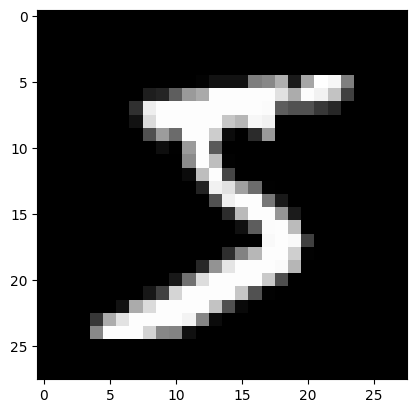

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img[0], cmap='gray')

In [ ]:
def split_indices(n, val_pct):
  # determine size of validation set
  n_val = int(val_pct*n)
  # create random permutations from 0 to n-1
  idxs = np.random.permutation(n)
  # pick first n_val indices for validation set
  return idxs[n_val:], idxs[:n_val]

In [ ]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

print(len(train_indices), len(val_indices))
print('Sample val indices: ', val_indices[:20])

48000 12000
Sample val indices:  [52980 37077 12855 25993 59244 17079 15646 21898 58202  6716 38984 25903
 57775 30643 10840 30725 49844 22120 53632 27799]


In [ ]:
batch_size=100

'''
 Essentialy what's happening here is, the dataloader loads data in the pre-specified no. of batches
 and takes only those indices specified by the sampler. The subsetrandomsampler in turns shuffles the
 data randomly each time before the dataloader gets the batch
'''

# training smapler and dataloader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                      batch_size,
                      sampler=train_sampler)

# validation sampler and data loader
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                      batch_size,
                      sampler=valid_sampler)

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
class MnistModel(nn.Module):
  ''' Neural network with 1 hidden layer '''
  def __init__(self, in_size, hidden_size, out_size):
    super().__init__()
    # hidden layer
    self.linear1 = nn.Linear(in_size, hidden_size)
    # output layer
    self.linear2 = nn.Linear(hidden_size, out_size)

  def forward(self, xb):
    # flatten the image tensors
    xb = xb.view(xb.size(0), -1)
    # get the inermediate output using hidden layer
    out = self.linear1(xb)
    # apply activation function
    out = F.relu(out)
    # get predictions using output layer
    out = self.linear2(out)
    return out


In [ ]:
input_size = 784
num_classes = 10

model = MnistModel(input_size,
                   hidden_size=32,
                   out_size=num_classes)

In [ ]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for images, labels in train_dl:
  print('images.shape', images.shape)
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('Loss: ', loss.item())
  break

print('Output.shape: ',outputs.shape)
print('Sample outputs: \n', outputs[:2].data)

images.shape torch.Size([100, 1, 28, 28])
Loss:  2.2756197452545166
Output.shape:  torch.Size([100, 10])
Sample outputs: 
 tensor([[ 0.0586,  0.0508,  0.1853,  0.0856, -0.1229, -0.1903, -0.0818,  0.2667,
         -0.0127, -0.1292],
        [-0.0791,  0.0765,  0.1064,  0.0222, -0.0975, -0.0755,  0.0751,  0.1544,
          0.0320, -0.0400]])


In [ ]:
torch.cuda.is_available()

False

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [ ]:
device = get_default_device()

In [ ]:
def loss_batch(model, loss_fn, xb, yb, opt=None, metric=None):
  # generate predictions
  preds = model(xb)
  # calculate loss
  loss = loss_fn(preds, yb)

  if opt is not None:
    # compute gradients
    loss.backward()
    # update parameters
    opt.step()
    # resert gradients
    opt.zero_grad()

  metric_result=None
  if metric is not None:
    # compute metric
    metric_result = metric(preds, yb)

  return loss.item(), len(xb), metric_result

In [ ]:
def evaluate(model, loss_fn, valid_dl, metric=None):
  with torch.no_grad():
    # pass each batch through the model
    results = [loss_batch(model, loss_fn, xb, yb, metric=metric)
    for xb, yb in valid_dl]
    # seperate losses, counts and metrics
    losses, nums, metrics = zip(*results)
    # total size of dataset
    total = np.sum(nums)
    # avg loss across batches
    avg_loss = np.sum(np.multiply(losses, nums))/total
    avg_metric = None
    if metric is not None:
      # avg metric across batches
      avg_metric = np.sum(np.multiply(metrics, nums))/total

    return avg_loss, total, avg_metric

In [ ]:
def fit(epochs, lr, model, loss_fn, train_dl,
        valid_dl, metric=None, opt_fn=None):
  losses, metrics = [], []

  # instantiate the optimizer
  if opt_fn is None: opt_fn = torch.optim.SGD
  opt = opt_fn(model.parameters(), lr=lr)

  for epoch in range(epochs):
    # training
    for xb, yb in train_dl:
      loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)

    # evaluation
    result = evaluate(model, loss_fn, valid_dl, metric)
    val_loss, total, val_metric = result

    # record the loss and metric
    losses.append(val_loss)
    metrics.append(val_metric)

    # print progress
    if metric is None:
      print('Epoch [{}/{}], Loss: {:.4f}'
      .format(epoch+1, epochs, val_loss))

    else:
      print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'
      .format(epoch+1, epochs, val_loss,
              metric.__name__, val_metric))

  return losses, metrics

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.sum(preds==labels).item()/len(preds)

In [ ]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [ ]:
val_loss, total, val_acc = evaluate(model, F.cross_entropy,
                                    valid_dl, metric=accuracy)
print(f"Loss: {val_loss:.4f}, accuracy: {val_acc:.4f}")

Loss: 2.3012, accuracy: 0.1288


In [ ]:
losses1, metrics1 = fit(5, 0.5, model, F.cross_entropy,
                        train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 0.2373, accuracy: 0.9293
Epoch [2/5], Loss: 0.1932, accuracy: 0.9431
Epoch [3/5], Loss: 0.1581, accuracy: 0.9518
Epoch [4/5], Loss: 0.1726, accuracy: 0.9483
Epoch [5/5], Loss: 0.1759, accuracy: 0.9482


In [ ]:
losses2, metrics2 = fit(5, 0.1, model, F.cross_entropy,
                        train_dl, valid_dl, accuracy)

Epoch [1/5], Loss: 0.1279, accuracy: 0.9639
Epoch [2/5], Loss: 0.1269, accuracy: 0.9634
Epoch [3/5], Loss: 0.1255, accuracy: 0.9645
Epoch [4/5], Loss: 0.1253, accuracy: 0.9633
Epoch [5/5], Loss: 0.1261, accuracy: 0.9643


In [ ]:
import matplotlib.pyplot as plt

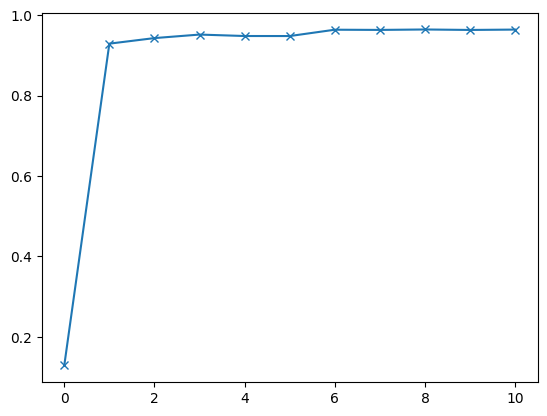

In [ ]:
accuracies = [val_acc] + metrics1 + metrics2

plt.plot(accuracies, '-x')